In [1]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm 
import statsmodels.tools as st
from patsy import dmatrices
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LassoCV, Lasso
import random 
import matplotlib.pyplot as plt

In [2]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

In [3]:
#MVP path merged = pd.read_csv("/shared/3/projects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"])

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#look at which outlet first started a story 

#first make sure we have the date of an outlet correctly specified 
merged["date"] = pd.to_datetime(merged["date"])


In [5]:
#load embeddings to be merged to the pairsDf 
embedDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/embeddingsKeys.tsv", sep="\t", names=["key", "embedding"], converters={"embedding":lambda x: np.array(x.strip("[]").split(","), dtype=float)})

In [6]:
df = pd.merge(merged, embedDf, on="key", how="inner")

In [163]:
#group data together 
grouped = df[["key", "source", "title", "content", "clustNum", "date", "national", "embedding"]].groupby(by="clustNum").agg(list)
grouped["clustLen"] = grouped["key"].apply(len)

#get first to publish within a cluster 
grouped["firstIndex"] = grouped["date"].apply(lambda x: x.index(min(x)))

NameError: name 'df' is not defined

In [8]:
grouped["nationalPercent"] = grouped["national"].apply(lambda x: np.mean(x) * 100)

In [9]:
grouped.head(3)

,key,source,title,content,date,national,embedding,clustLen,first,nationalPercent
clustNum,,,,,,,,,,
0.0,"[12619, 28945, 43496, 43909, 43933, 44063, 442...","[newyorkobserver, newyorkobserver, dailyherald...",[Prince Harry and Meghan Are Keeping Busy Whil...,[The Duke and Duchess of Sussex made their mov...,"[2020-04-07 00:00:00, 2020-04-14 00:00:00, 202...","[False, False, False, False, False, False, Fal...","[[-0.04176515340805054, 0.12626628577709198, -...",1253,397,94.972067
1.0,"[25945, 117195, 227832, 227858, 227989, 231314...","[newyorkobserver, thedailyrepublic, murrysvill...",[Bob Iger Reasserts Control Over Disney Amid C...,"[For years, the entertainment media industry s...","[2020-04-13 00:00:00, 2020-05-18 00:00:00, 202...","[False, False, False, False, False, False, Fal...","[[0.06171561777591705, 0.10853632539510727, -0...",1578,1405,82.636248
2.0,"[1857674, 2283482, 2283499, 2613520, 2660920]","[dcgazette, themichellemalkinblog, themichelle...",[Crisis Socialism: No Bailouts for Open Border...,[Crisis Socialism : No Bailouts for Open Borde...,"[2020-03-19 00:00:00, 2020-03-18 00:00:00, 202...","[True, True, True, True, True]","[[-0.16683174669742584, 0.18352562189102173, -...",5,1,100.000000


In [10]:
toRegress = grouped[["embedding", "nationalPercent"]].explode("embedding")

In [11]:
#first we want to get our embeddings into an array
embeddingsArr = np.array(list(toRegress["embedding"]))

embeddingsArr = st.tools.add_constant(embeddingsArr)

In [12]:
natPArr = np.array(toRegress["nationalPercent"])

In [13]:
natPModel = sm.regression.linear_model.OLS(natPArr, embeddingsArr).fit()

# summary:  
gave no "significant" predictors, but an adjusted R^2 of .587. Also a very significant F statistic. 
the lack of significant predictors is likely due to very high multicolinearity? 

In [25]:
sum(natPModel.params) / 10

-8505913276.740344

In [26]:
natPLasso = sm.regression.linear_model.OLS(natPArr, embeddingsArr).fit_regularized(method="elastic_net", alpha=.5, L1_wt=1, refit=True)

# Summary: 
(adj.) R-squared = .314 
only 7 parameters used (including intercept), all significant 

In [29]:
len([param for param in natPLasso.params if param > 0])

7

In [30]:
#natPLasso.summary()

In [31]:
natPLasso = sm.regression.linear_model.OLS(natPArr, embeddingsArr).fit_regularized(method="elastic_net", alpha=.2, L1_wt=1, refit=True)

In [33]:
len([param for param in natPLasso.params if param > 0])

24

# Summary: 
(adj.) R-squared = .449 
only 24 parameters (including intercept), all significant 

In [9]:
merged.head(3)

,Unnamed: 0,key,local_id,sourcedomain_id,date,title,content,url,fips,source,...,predrt_12,predrt_3,national,id,author,published,published_utc,collection_utc,year,clustNum
2,2,2,andalusiastarnews--2020-04-04--Governor issues...,andalusiastarnews-andalusiastarnews.com,2020-04-04,Governor issues stay at home order,Governor Kay Ivey announced that a stay at hom...,https://www.andalusiastarnews.com/2020/04/03/g...,1039.0,andalusiastarnews,...,44.15,30.80,False,NaN,NaN,NaN,NaN,NaN,2020,7.0
12,12,12,atmoreadvance--2020-04-03--COVID-19: Statewide...,atmoreadvance-atmoreadvance.com,2020-04-03,COVID-19: Statewide ‘stay-at-home’ order issued,State officials issued a statewide stay-at-hom...,https://www.atmoreadvance.com/2020/04/03/covid...,1053.0,atmoreadvance,...,43.97,31.68,False,NaN,NaN,NaN,NaN,NaN,2020,7.0
20,20,20,thebrewtonstandard--2020-04-03--Gov. Ivey issu...,thebrewtonstandard-brewtonstandard.com,2020-04-03,Gov. Ivey issues Stay at Home Order,Governor Kay Ivey on Friday issued a Stay at H...,https://www.brewtonstandard.com/2020/04/03/gov...,1053.0,thebrewtonstandard,...,43.97,31.68,False,NaN,NaN,NaN,NaN,NaN,2020,7.0


# Get Lemmas 

In [58]:
#make sure we can open the file 
lemmDf = pd.read_csv(LEMMAS_OUTFILE, sep="\t", names=["key", "lemmas"])
lemmDf.tail(4)

,key,lemmas
1996,4636,"PRESCOTT , Ariz. ( AP ) — a housekeeping emplo..."
1997,4638,President Donald Trump meet by phone with many...
1998,4639,MEXICO CITY ( AP ) — a former president of Hon...
1999,4640,as New York City erupt in coronavirus infectio...


In [51]:
len(lemmDf)

1000

In [5]:
#group data together 
grouped = merged[["key", "source", "title", "content", "clustNum", "date", "national"]].groupby(by="clustNum").agg(list)
grouped["clustLen"] = grouped["key"].apply(len)

#get first to publish within a cluster 
grouped["firstIndex"] = grouped["date"].apply(lambda x: x.index(min(x)))

grouped["nationalPercent"] = grouped["national"].apply(lambda x: np.mean(x) * 100)

In [6]:
grouped["natFirst"] = grouped.apply(lambda x: x["national"][x["firstIndex"]], axis=1)

In [7]:
leanDf = grouped[["content", "nationalPercent", "natFirst"]].explode(["content"])

In [ ]:

#def getBOW(): 
count_vect = CountVectorizer(stop_words="english", max_features=50000)
doc_counts = count_vect.fit_transform(leanDf["content"])
vocab_dict = count_vect.vocabulary_
vocab_indices = {value:key for key, value in vocab_dict.items()}

In [ ]:
tfTransform = TfidfTransformer(use_idf=False, norm="l1")

In [ ]:
doc_tfs = tfTransform.fit_transform(doc_counts)
#dense_doc_tfs = doc_tfs.todense()

rows = doc_tfs.shape[0]
doc_tfs.shape

In [ ]:
#grab one tenth of the data and find alpha value for lasso using that 
sampleIndices = random.sample(list(range(0, rows)), int(rows/100))
sampleFeatures = doc_tfs[sampleIndices]
sampleResponse = leanDf.iloc[sampleIndices, ]["nationalPercent"]

In [ ]:
print(sampleFeatures.shape)

In [378]:
LCV = Lasso(alpha=.005)
model = LCV.fit(sampleFeatures, sampleResponse)

In [17]:
def get_coeffs(inModel): 
    def getTerm(index): 
        return vocab_indices[index]

    indices = [i for i, coef in enumerate(inModel.coef_) if coef != 0]
    coeffs = [coef for coef in inModel.coef_ if coef != 0]
    features = [getTerm(i) for i in range(0, sampleFeatures.shape[1]) if inModel.coef_[i] != 0]

    return (indices, features, coeffs)

In [380]:
indices, features, coeffs = get_coeffs(model)

In [381]:
len(features)

75

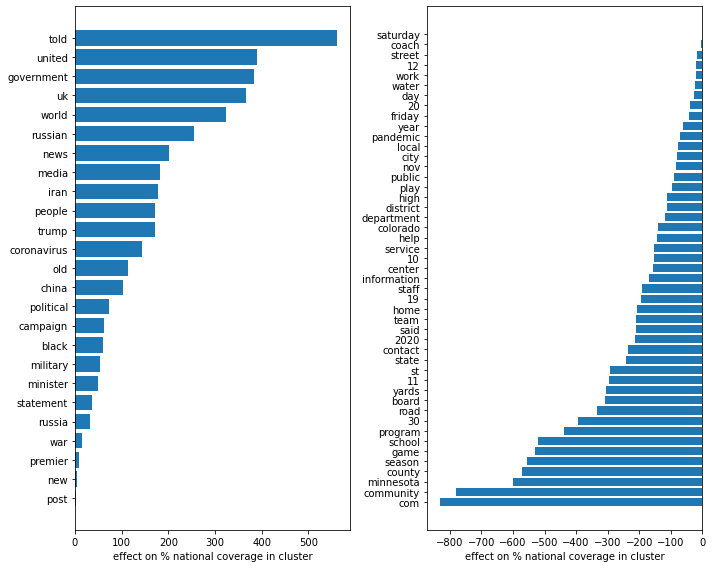

In [382]:
smFeatures = sampleFeatures[:, indices].todense()
smFeatures = sm.tools.tools.add_constant(smFeatures)
sModel = sm.regression.linear_model.OLS(sampleResponse, smFeatures).fit()

temp = pd.DataFrame({"features":features, "coeffs":coeffs, "pvals":sModel.pvalues[1:]}).sort_values("coeffs")
temp = temp[temp["pvals"] <= .05]

#TODO: keep this approach but sort it and add some colors for pos/neg if time 
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
indices, features, coeffs = get_coeffs(model)
tempPos = temp[temp["coeffs"] > 0]
ax[0].barh(tempPos["features"], tempPos["coeffs"])
ax[0].set_xlabel("effect on % national coverage in cluster")

tempNeg = temp[temp["coeffs"] < 0]
ax[1].barh(tempNeg["features"], tempNeg["coeffs"])
ax[1].set_xlabel("effect on % national coverage in cluster")
plt.tight_layout()

In [389]:
sModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natFirst   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     56.09
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:25:14   Log-Likelihood:                -5430.6
No. Observations:               12660   AIC:                         1.101e+04
Df Residuals:                   12585   BIC:                         1.157e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8656      0.009     97.050      0.000       0.848       0.883
x1            -5.3090      1.237     -4.292      0.000      -7.733      -2.885
x2            -1.2129      0.646     -1.876      0.061      -2.480       0.054
x3            -2.8327      0.730     -3.883      0.000      -4.263      -1.403
x4            -4.5943      1.083     -4.242      0.000      -6.717      -2.471
x5             5.0693      1.273      3.982      0.000       2.574       7.565
x6             1.5121      0.508      2.975      0.003       0.516       2.508
x7            -5.8684      1.050     -5.587      0.000      -7.927      -3.809
x8             3.5566      0.981      3.627      0.000       1.634       5.479
x9             3.2086      0.625      5.137      0.000       1.984       4.433
x10           -5.5255      1.292     -4.278      0.000      -8.057      -2.993
x11            1.7214      0.796      2.162      0.031       0.161       3.282
x12           -1.9624      0.574     -3.422      0.001      -3.087      -0.838
x13          -11.5204      1.759     -6.549      0.000     -14.969      -8.072
x14           -8.1581      1.491     -5.470      0.000     -11.081      -5.235
x15          -12.1846      1.160    -10.503      0.000     -14.459      -9.911
x16          -11.2613      1.197     -9.406      0.000     -13.608      -8.915
x17           -7.1381      1.354     -5.271      0.000      -9.793      -4.484
x18            3.2597      0.606      5.380      0.000       2.072       4.447
x19           -5.7236      0.499    -11.467      0.000      -6.702      -4.745
x20            5.4416      1.300      4.187      0.000       2.894       7.989
x21           -2.1162      0.756     -2.800      0.005      -3.598      -0.635
x22           -3.6797      1.028     -3.581      0.000      -5.694      -1.665
x23            2.4570      0.727      3.381      0.001       1.033       3.881
x24           -3.5727      0.994     -3.595      0.000      -5.521      -1.625
x25           -1.5726      0.881     -1.785      0.074      -3.300       0.155
x26            4.2136      0.786      5.361      0.000       2.673       5.754
x27           -5.4626      1.100     -4.967      0.000      -7.618      -3.307
x28           -3.7495      1.024     -3.662      0.000      -5.757      -1.742
x29           -4.0196      0.820     -4.899      0.000      -5.628      -2.411
x30           -4.0610      1.006     -4.037      0.000      -6.033      -2.089
x31            3.0949      0.909      3.404      0.001       1.313       4.877
x32           -5.1087      1.143     -4.468      0.000      -7.350      -2.867
x33            2.2402      0.861      2.601      0.009       0.552       3.928
x34           -9.1286      1.264     -7.220      0.000     -11.607      -6.650
x35            1.9417      0.790      2.459      0.014       0.394       3.489
x3

In [383]:
sampleResponse = leanDf.iloc[sampleIndices, ]["natFirst"].astype(int)

In [384]:
LCV = Lasso(alpha=.00005)
model = LCV.fit(sampleFeatures, sampleResponse)

In [385]:
indices, features, coeffs = get_coeffs(model)
len(features)

74

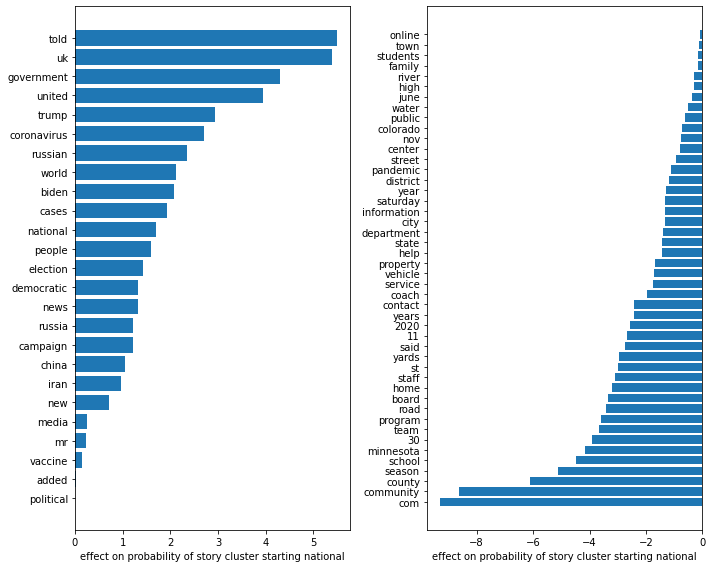

In [388]:
smFeatures = sampleFeatures[:, indices].todense()
smFeatures = sm.tools.tools.add_constant(smFeatures)
sModel = sm.regression.linear_model.OLS(sampleResponse, smFeatures).fit()

temp = pd.DataFrame({"features":features, "coeffs":coeffs, "pvals":sModel.pvalues[1:]}).sort_values("coeffs")
temp = temp[temp["pvals"] <= .05]

#TODO: keep this approach but sort it and add some colors for pos/neg if time 
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
indices, features, coeffs = get_coeffs(model)
tempPos = temp[temp["coeffs"] > 0]
ax[0].barh(tempPos["features"], tempPos["coeffs"])
ax[0].set_xlabel("effect on probability of story cluster starting national")

tempNeg = temp[temp["coeffs"] < 0]
ax[1].barh(tempNeg["features"], tempNeg["coeffs"])
ax[1].set_xlabel("effect on probability of story cluster starting national")
plt.tight_layout()

In [ ]:
#TODO: try to predict stories in the middle using a binary indicator variable 
#maybe some sort of random forest regressor? something like that? 
#try subsetting mixed stories then rerunning? 

In [8]:
leanDf["middle"] = (leanDf["nationalPercent"] >= 25) | (leanDf["nationalPercent"] <= 75) 

In [9]:
sampleResponse = leanDf.iloc[sampleIndices, ]["middle"].astype(int)

NameError: name 'sampleIndices' is not defined

In [ ]:
LCV = Lasso(alpha=10)
model = LCV.fit(sampleFeatures, sampleResponse)

In [ ]:
LCV = Lasso(alpha=.00005)
indices, features, coeffs = get_coeffs(model)
len(features)

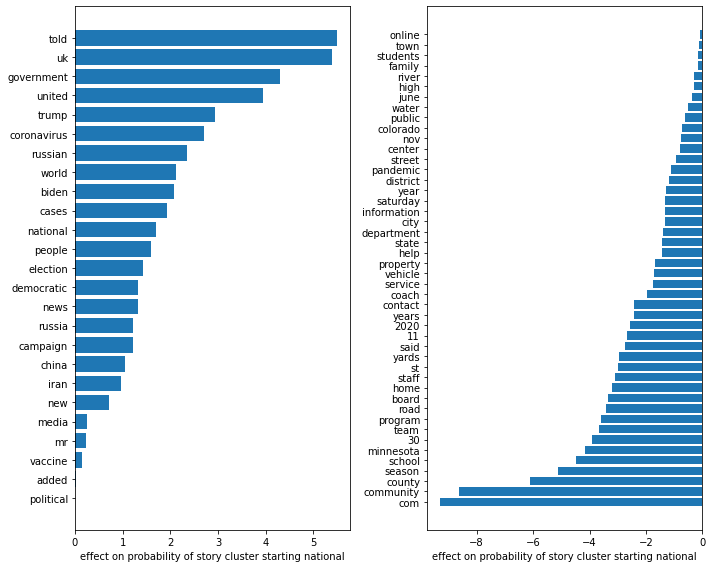

In [404]:
smFeatures = sampleFeatures[:, indices].todense()
smFeatures = sm.tools.tools.add_constant(smFeatures)
sModel = sm.regression.linear_model.OLS(sampleResponse, smFeatures).fit()

temp = pd.DataFrame({"features":features, "coeffs":coeffs, "pvals":sModel.pvalues[1:]}).sort_values("coeffs")
temp = temp[temp["pvals"] <= .05]

#TODO: keep this approach but sort it and add some colors for pos/neg if time 
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
indices, features, coeffs = get_coeffs(model)
tempPos = temp[temp["coeffs"] > 0]
ax[0].barh(tempPos["features"], tempPos["coeffs"])
ax[0].set_xlabel("effect on probability of story cluster starting national")

tempNeg = temp[temp["coeffs"] < 0]
ax[1].barh(tempNeg["features"], tempNeg["coeffs"])
ax[1].set_xlabel("effect on probability of story cluster starting national")
plt.tight_layout()

In [10]:
middleStories = leanDf[(leanDf["nationalPercent"] >= 25) & (leanDf["nationalPercent"] <= 75)]

In [11]:
len(middleStories)

152751

In [12]:
#def getBOW(): 
count_vect = CountVectorizer(stop_words="english", max_features=50000)
doc_counts = count_vect.fit_transform(middleStories["content"])
vocab_dict = count_vect.vocabulary_
vocab_indices = {value:key for key, value in vocab_dict.items()}

tfTransform = TfidfTransformer(use_idf=False, norm="l1")
doc_tfs = tfTransform.fit_transform(doc_counts)


In [13]:
rows = doc_tfs.shape[0]
doc_tfs.shape

#grab one tenth of the data and find alpha value for lasso using that 
sampleIndices = random.sample(list(range(0, rows)), int(rows/100))
sampleFeatures = doc_tfs[sampleIndices]
sampleResponse = middleStories.iloc[sampleIndices,]["natFirst"]

In [33]:
LCV = Lasso(alpha=.00006)
model = LCV.fit(sampleFeatures, sampleResponse)

In [34]:
indices, features, coeffs = get_coeffs(model)

In [35]:
len(features)

77

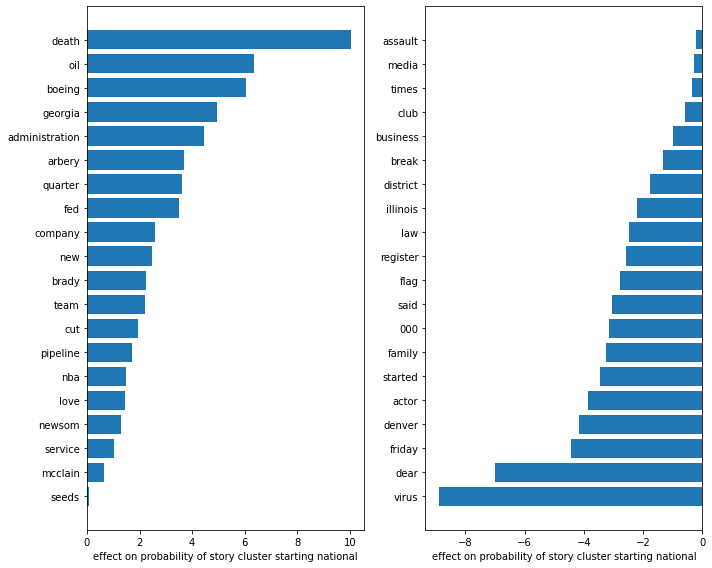

In [36]:
smFeatures = sampleFeatures[:, indices].todense()
smFeatures = sm.tools.tools.add_constant(smFeatures)
sModel = sm.regression.linear_model.OLS(sampleResponse, smFeatures).fit()

temp = pd.DataFrame({"features":features, "coeffs":coeffs, "pvals":sModel.pvalues[1:]}).sort_values("coeffs")
temp = temp[temp["pvals"] <= .05]

#TODO: keep this approach but sort it and add some colors for pos/neg if time 
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
indices, features, coeffs = get_coeffs(model)
tempPos = temp[temp["coeffs"] > 0]
ax[0].barh(tempPos["features"], tempPos["coeffs"])
ax[0].set_xlabel("effect on probability of story cluster starting national")

tempNeg = temp[temp["coeffs"] < 0]
ax[1].barh(tempNeg["features"], tempNeg["coeffs"])
ax[1].set_xlabel("effect on probability of story cluster starting national")
plt.tight_layout()

In [41]:
np.mean(merged.head(3)["date"])

Timestamp('2020-04-03 08:00:00')

In [47]:
def getDaysApart(inRow): 
    national = [inRow["date"][i] for i, natLab in enumerate(inRow["national"]) if natLab == True]
    local = [inRow["date"][i] for i, natLab in enumerate(inRow["national"]) if natLab == False]
    
    natDiff = np.mean(national) - np.mean(local)
    natDiff = natDiff.days

In [48]:
grouped.head(15).apply(getDaysApart, axis=1)

<ipython-input-47-3cc71644b25f>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  natDiff = pd.datetime(np.mean(national)) - pd.datetime(np.mean(local))


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

In [37]:
sModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               natFirst   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     6.151
Date:                Thu, 30 Mar 2023   Prob (F-statistic):           1.04e-48
Time:                        11:35:34   Log-Likelihood:                -887.21
No. Observations:                1527   AIC:                             1930.
Df Residuals:                    1449   BIC:                             2346.
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5285      0.036     14.491      0.000       0.457       0.600
x1            -6.1930      3.121     -1.984      0.047     -12.316      -0.070
x2             7.0822      4.731      1.497      0.135      -2.197      16.362
x3             2.4694      2.522      0.979      0.328      -2.477       7.416
x4             7.6586      6.244      1.227      0.220      -4.590      19.907
x5           -18.2877      5.663     -3.229      0.001     -29.396      -7.179
x6            11.5500      5.109      2.261      0.024       1.528      21.572
x7            14.3261      4.749      3.016      0.003       5.010      23.642
x8            -7.3643      4.289     -1.717      0.086     -15.778       1.049
x9           -18.0546      6.680     -2.703      0.007     -31.157      -4.952
x10            9.4522      4.866      1.942      0.052      -0.093      18.997
x11            4.1223      3.229      1.277      0.202      -2.212      10.457
x12           11.9252      3.965      3.007      0.003       4.147      19.704
x13            8.0384      3.955      2.032      0.042       0.280      15.797
x14          -21.3226      6.552     -3.254      0.001     -34.175      -8.470
x15          -15.7741      5.501     -2.868      0.004     -26.564      -4.984
x16           -8.0451      4.132     -1.947      0.052     -16.151       0.061
x17            5.1239      2.952      1.736      0.083      -0.667      10.915
x18           -2.9498      3.417     -0.863      0.388      -9.652       3.752
x19           -2.7450      2.342     -1.172      0.241      -7.339       1.849
x20          -17.3152      5.929     -2.920      0.004     -28.946      -5.685
x21            7.6707      3.293      2.329      0.020       1.211      14.131
x22            3.1179      4.885      0.638      0.523      -6.465      12.700
x23           -5.6748      3.744     -1.516      0.130     -13.018       1.669
x24            0.3568      2.477      0.144      0.886      -4.503       5.217
x25            3.9082      3.109      1.257      0.209      -2.191      10.008
x26           14.8289      6.980      2.124      0.034       1.137      28.521
x27          -17.3030      4.934     -3.507      0.000     -26.981      -7.625
x28           13.2478      3.396      3.901      0.000       6.586      19.910
x29           -8.1119      3.302     -2.456      0.014     -14.590      -1.634
x30           -6.4964      4.261     -1.525      0.128     -14.854       1.861
x31           -7.1957      3.629     -1.983      0.048     -14.314      -0.078
x32           -6.8162      3.411     -1.998      0.046     -13.508      -0.125
x33           12.4289      5.235      2.374      0.018       2.160      22.698
x34            2.8972      3.237      0.895      0.371      -3.453       9.247
x35           -7.0059      2.908     -2.409      0.016     -12.710      -1.301
x3

In [290]:
temp = pd.DataFrame({"features":features, "coeffs":coeffs}).sort_values("coeffs")

33


Text(0.5, 0, 'effect on national starting the story')

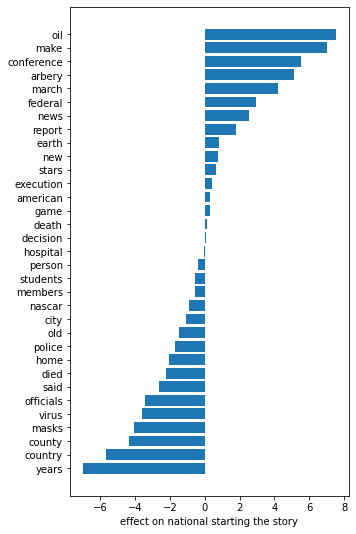

In [296]:
#TODO: keep this approach but sort it and add some colors for pos/neg if time 
fig, ax = plt.subplots(figsize=(5, 9))
plt.barh(temp["features"], temp["coeffs"])
print(len(features))
plt.xlabel("effect on national starting the story")

# Interesting from above
"masks" is started by local? 
"death" is local, makes sense 
"nascar" starts local? 

In [133]:
"""
LCV = LassoCV(n_alphas=10, max_iter=500, cv=3)
LCV.fit(sampleFeatures, sampleResponse)
"""

'\nLCV = LassoCV(n_alphas=10, max_iter=500, cv=3)\nLCV.fit(sampleFeatures, sampleResponse)\n'

# Look at topics

In [298]:
#load in topics for documents 
docTopics = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/topicModelling/doc_topics.txt", sep="\t", nrows=19)

In [299]:
#topics are fucked... 

,0,2428066,0.008928571428571428,0.008928571428571428.1,0.008928571428571428.2,0.008928571428571428.3,0.008928571428571428.4,0.008928571428571428.5,0.008928571428571428.6,0.08035714285714286,...,0.008928571428571428.28,0.008928571428571428.29,0.15178571428571427,0.008928571428571428.30,0.15178571428571427.1,0.22321428571428573,0.008928571428571428.31,0.008928571428571428.32,0.008928571428571428.33,0.008928571428571428.34
0,1,A,0.006944,0.006944,0.006944,0.506944,0.006944,0.006944,0.006944,0.006944,...,0.118056,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.062500,0.006944,0.006944
1,2,A,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.075000,0.008333,0.008333,0.008333
2,3,The,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.284722,...,0.062500,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944,0.006944
3,4,The,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,...,0.012500,0.012500,0.012500,0.012500,0.012500,0.212500,0.012500,0.012500,0.012500,0.012500
4,5,Another,0.007812,0.007812,0.007812,0.007812,0.007812,0.070312,0.070312,0.007812,...,0.007812,0.007812,0.070312,0.007812,0.070312,0.007812,0.007812,0.007812,0.007812,0.007812
5,6,A,0.195312,0.007812,0.007812,0.007812,0.007812,0.007812,0.007812,0.007812,...,0.007812,0.007812,0.007812,0.007812,0.132812,0.007812,0.070312,0.007812,0.007812,0.007812
6,7,To,0.106250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,...,0.156250,0.006250,0.006250,0.006250,0.006250,0.056250,0.006250,0.006250,0.006250,0.006250
7,8,In,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.141667,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
8,9,The,0.007353,0.066176,0.007353,0.007353,0.183824,0.007353,0.007353,0.007353,...,0.007353,0.007353,0.007353,0.007353,0.360294,0.007353,0.007353,0.007353,0.007353,0.066176
9,10,Colin,0.005682,0.051136,0.005682,0.005682,0.005682,0.005682,0.005682,0.005682,...,0.005682,0.005682,0.142045,0.005682,0.278409,0.005682,0.005682,0.051136,0.005682,0.005682
